In [1]:
import json
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/abey/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
data_dir = "BrainTumorDataset"

In [3]:
def load_coco_annotations(json_file):
    """
    Loads and returns the annotations from a COCO-style JSON file.

    Args:
        json_file (str): Path to the COCO annotations JSON file.

    Returns:
        dict: Dictionary containing images, annotations, and categories.
            - images: List of image metadata.
            - annotations: List of annotation objects.
            - categories: List of category definitions.
    """
    try:
        with open(json_file, 'r') as file:
            coco_data = json.load(file)
        
        # Extract specific sections
        images = coco_data.get('images', [])
        annotations = coco_data.get('annotations', [])
        categories = coco_data.get('categories', [])
        
        return {
            'images': images,
            'annotations': annotations,
            'categories': categories
        }
    except FileNotFoundError:
        print(f"Error: File '{json_file}' not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON file '{json_file}'.")
        return None

In [4]:
# Load the train/validation/test annotations and store in a dictionary
train_annotations_path = f'{data_dir}/train/_annotations.coco.json'
valid_annotations_path = f'{data_dir}/valid/_annotations.coco.json'
test_annotations_path = f'{data_dir}/test/_annotations.coco.json'

train_annotations_dict = load_coco_annotations(train_annotations_path)

In [40]:
print(train_annotations_dict['annotations'])

[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [145, 239, 168.75, 162.5], 'area': 27421.875, 'segmentation': [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]], 'iscrowd': 0}, {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [194, 176, 148.75, 233.75], 'area': 34770.313, 'segmentation': [[342.5, 176.25, 193.75, 176.25, 193.75, 410, 342.5, 410, 342.5, 176.25]], 'iscrowd': 0}, {'id': 2, 'image_id': 2, 'category_id': 1, 'bbox': [133, 173, 162.5, 185], 'area': 30062.5, 'segmentation': [[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295, 357.5, 295, 172.5]], 'iscrowd': 0}, {'id': 3, 'image_id': 3, 'category_id': 1, 'bbox': [245, 358, 138.75, 166.25], 'area': 23067.188, 'segmentation': [[383.75, 357.5, 245, 357.5, 245, 523.75, 383.75, 523.75, 383.75, 357.5]], 'iscrowd': 0}, {'id': 4, 'image_id': 4, 'category_id': 1, 'bbox': [80, 189, 112.5, 132.5], 'area': 14906.25, 'segmentation': [[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5, 321.25, 192.5, 188.75]], 'iscrowd': 

In [27]:
def generate_segmentation_masks_brain_tumor(annotation_file, image_dir, mask_dir):
    """
    Generates binary segmentation masks for a brain tumor dataset.

    Args:
        annotation_file (str): Path to the COCO annotations JSON file.
        image_dir (str): Directory containing images.
        mask_dir (str): Directory to save generated masks.

    Returns:
        None
    """
    # Load COCO annotations
    coco = COCO(annotation_file)
    os.makedirs(mask_dir, exist_ok=True)
    
    for img_id in coco.getImgIds():
        # Load image metadata
        img_info = coco.loadImgs(img_id)[0]
        image_path = os.path.join(image_dir, img_info['file_name'])
        
        # Load annotations for the image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        # Create an empty binary mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        
        for ann in annotations:
            if ann['segmentation']:
                for seg in ann['segmentation']:
                    # Convert segmentation to Nx2 array of coordinates
                    polygon = np.array(seg, dtype=np.int32).reshape((-1, 2))

                    print(f"Processing Image: {img_info['file_name']} with annotation:", ann['category_id'])

                    # Set mask based on category_id
                    if ann['category_id'] == 1:  # No tumor
                        cv2.fillPoly(mask, [polygon], color=0)  # Explicitly set to background (no tumor)
                    elif ann['category_id'] == 2:  # Tumor present
                        cv2.fillPoly(mask, [polygon], color=255)  # Explicitly set to foreground (tumor)

        # Validate mask values (should only contain 0 and 1)
        mask[mask > 1] = 1
        
        # Save the mask
        mask_filename = f"{img_info['file_name'].split('.jpg')[0]}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        cv2.imwrite(mask_path, mask)  # Save as grayscale (0 and 1)

In [28]:
# Create directories to store the original images and created masks for the train, validation, and test datasets
train_image_path = f'{data_dir}/train/images/'
train_mask_path = f'{data_dir}/train/mask/'
valid_image_path = f'{data_dir}/valid/images/'
valid_mask_path = f'{data_dir}/valid/mask/'
test_image_path = f'{data_dir}/test/images/'
test_mask_path = f'{data_dir}/test/mask/'

In [29]:
# Create the masks for each image, a category ID = 1 signifies no tumor and category ID = 2 signifies a tumor is present
generate_segmentation_masks_brain_tumor(train_annotations_path, train_image_path, train_mask_path)
generate_segmentation_masks_brain_tumor(valid_annotations_path, valid_image_path, valid_mask_path)
generate_segmentation_masks_brain_tumor(test_annotations_path, test_image_path, test_mask_path)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Processing Image: 2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg with annotation: 1
Processing Image: 2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg with annotation: 1
Processing Image: 2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg with annotation: 1
Processing Image: 2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg with annotation: 1
Processing Image: 2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg with annotation: 1
Processing Image: 2161_jpg.rf.3be4125d1ffe011c0ed462d9fe0d2152.jpg with annotation: 1
Processing Image: 2265_jpg.rf.3c62c7b8825039fab853256f9a9fe141.jpg with annotation: 1
Processing Image: 1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg with annotation: 2
Processing Image: 1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg with annotation: 2
Processing Image: 2534_jpg.rf.3c8c86666860368d46b8f7bcd95ac220.jpg with annotation: 1
Processing Image: 2433_jpg.rf.3cdf8e4cb3a08e9b2fccc6c6082

In [7]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.mask_filenames = os.listdir(mask_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Convert images to RGB since the FCN_Resnet model is pretrained on ImageNet, which uses 
        # 3-channel RGB images
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].long()
            
        image_filename = os.path.basename(image_path)

        return image, mask, image_filename

In [8]:
# Define transforms for both image and mask
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=5, p=0.5),
    A.Affine(translate_percent=(0.1, 0.1), p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),  # Applied only to image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})  # Ensures mask is transformed with the same spatial ops

valid_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [30]:
# Create the datasets and dataloaders
train_dataset = BrainTumorDataset(train_image_path, train_mask_path, train_transform)
valid_dataset = BrainTumorDataset(valid_image_path, valid_mask_path, valid_transform)
test_dataset = BrainTumorDataset(test_image_path, test_mask_path, test_transform)

In [10]:
# Define the dice loss metric
def dice_loss(pred, target, epsilon=1e-6):
    # Apply softmax to get probabilities for each class from the logits
    pred = F.softmax(pred, dim=1)

    # Normalize target to binary values (0 and 1)
    target = (target > 0).long()  # Convert any nonzero value to 1

    # One-hot encode the target
    target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2)
    
    # Flatten the predictions and target
    pred_flat = pred.view(pred.shape[0], pred.shape[1], -1)
    target_flat = target_one_hot.view(target_one_hot.shape[0], target_one_hot.shape[1], -1)

    # Compute the intersection and union
    intersection = torch.sum(pred_flat * target_flat, dim=2)
    union = torch.sum(pred_flat, dim=2) + torch.sum(target_flat, dim=2)

    # Dice coefficient and loss
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    return 1 - dice.mean()

In [11]:
# Define focal loss for binary segmentation
def focal_loss(pred, target, alpha=1.0, gamma=2.0):
    ce_loss = F.cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-ce_loss) # get logits
    focal = alpha * (1 - pt) ** gamma * ce_loss

    return focal.mean()

In [12]:
# Combined focal and dice loss
def combined_dice_focal_loss(pred, target, alpha=1.0, gamma=2.0, dice_weight=1.0, focal_weight=1.0):
    dice = dice_loss(pred, target)
    focal = focal_loss(pred, target, alpha, gamma)

    return dice_weight * dice + focal_weight * focal

In [20]:
def combined_dice_ce_loss(pred, target, dice_weight=1.0, ce_weight=1.0):
    dice = dice_loss(pred, target)
    ce = F.cross_entropy(pred, target)

    return dice_weight * dice + ce_weight * ce

In [13]:
# Define learning rate scheduler with warmup period
def get_linear_warmup_scheduler(optimizer, base_lr, num_epochs, num_warmup=3):
    def lr_lambda(epoch):
        return min(1.0, (epoch+1) / num_warmup)

    return lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [37]:
# Load the pretrained resnet model and adapt for segmentation with 2 classes (tumor/no tumor)
model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)

In [38]:
# Set hyperparameters
criterion = lambda pred, target: combined_dice_ce_loss(pred, target, dice_weight=1.3, ce_weight=0.7)
batch = 32
learning_rate = 0.001
decay = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=decay)
num_epochs = 15
scheduler = get_linear_warmup_scheduler(optimizer, learning_rate, num_epochs)
best_model_path = "best_model.pth"  # Path to save the best model based on validation loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

In [39]:
# Training loop
model.to(device)

# Store the model with the best performance on the validation set
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    print(f"Epoch {epoch+1}: LR = {scheduler.get_last_lr()[0]:.6f}")

    for images, masks, files in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Train Combined Loss: {train_loss:.4f}")

    # Evaluate performance on validation dataset
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for images, masks, files in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(valid_loader)
    print(f"Validation Loss: {avg_valid_loss:.4f}")

    # Save the model if it has the lowest validation loss
    if avg_valid_loss < best_val_loss:
        best_val_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with average validation combined loss: {best_val_loss:.4f}")

    # Step the LR scheduler
    scheduler.step()

Epoch 1: LR = 0.000333
Epoch [1/15], Avg Train Combined Loss: 0.8137
Validation Loss: 0.6985
New best model saved with average validation combined loss: 0.6985
Epoch 2: LR = 0.000667
Epoch [2/15], Avg Train Combined Loss: 0.6402
Validation Loss: 0.6250
New best model saved with average validation combined loss: 0.6250
Epoch 3: LR = 0.001000
Epoch [3/15], Avg Train Combined Loss: 0.6150
Validation Loss: 0.6186
New best model saved with average validation combined loss: 0.6186
Epoch 4: LR = 0.001000
Epoch [4/15], Avg Train Combined Loss: 0.6160
Validation Loss: 0.6245
Epoch 5: LR = 0.001000
Epoch [5/15], Avg Train Combined Loss: 0.6070
Validation Loss: 0.6235
Epoch 6: LR = 0.001000
Epoch [6/15], Avg Train Combined Loss: 0.6039
Validation Loss: 0.6160
New best model saved with average validation combined loss: 0.6160
Epoch 7: LR = 0.001000
Epoch [7/15], Avg Train Combined Loss: 0.6042
Validation Loss: 0.6199
Epoch 8: LR = 0.001000
Epoch [8/15], Avg Train Combined Loss: 0.6023
Validation L

In [18]:
# Evaluate performance on the test set and display a few samples
model.load_state_dict(torch.load(best_model_path, weights_only=True))

model.eval()

test_loss = 0
num_samples_to_display = 1
sampled_images = []

with torch.no_grad():
    for idx, (images, masks, filenames) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']

        loss = combined_loss(outputs, masks)
        test_loss += loss.item()

        # Convert masks to binary (0 = no tumor, 1 = tumor)
        binary_masks = (masks > 0).long()  # Ensure binary values

        # Iterate over the batch
        for i in range(len(filenames)):  
            tumor_present = binary_masks[i].cpu().numpy().any()  # Check if any pixel in the mask has a tumor
            
            # Store images for visualization
            if tumor_present and len(sampled_images) < num_samples_to_display:
                sampled_images.append((images[i].cpu(), masks[i].cpu(), outputs[i].cpu(), filenames[i]))

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.4200


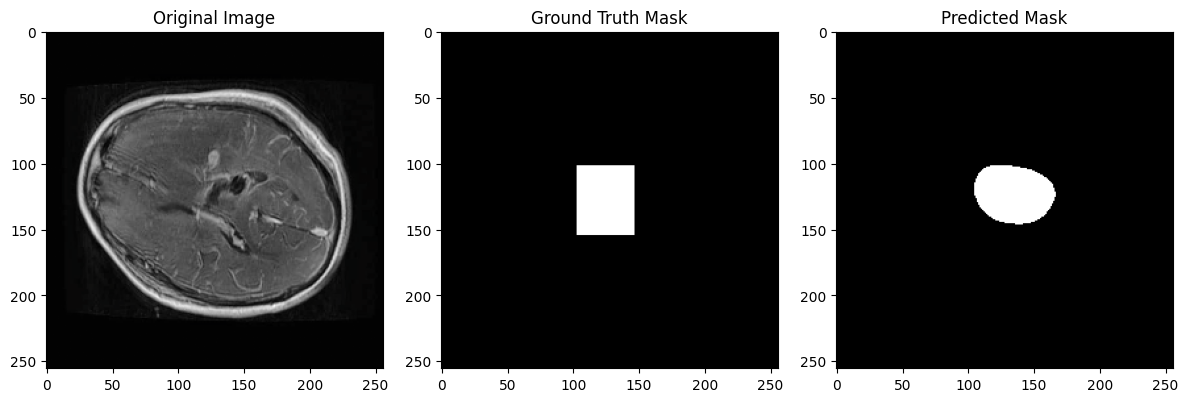

In [19]:
# ImageNet normalization settings
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3).to(device)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 3 columns

for i, (image, mask, output, filename) in enumerate(sampled_images):    
    # Ensure the image is in HxWxC format (for grayscale, just (H, W), RGB will have (H, W, C))
    image = image.permute(1, 2, 0).numpy()  # Convert to HxWxC (RGB or Grayscale)
    
    # Denormalize the image if needed
    image = image * std.cpu().numpy() + mean.cpu().numpy()
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
    
    # Convert mask and output to numpy (for visualization)
    mask = mask.numpy()
    output = output.argmax(dim=0).numpy()  # For predicted mask (assumes softmax output)

    # Plot the images, mask, and predicted mask
    axes[0].imshow(image, cmap="gray")  # Original Image
    axes[0].set_title("Original Image")
    axes[1].imshow(mask, cmap="gray")  # Ground truth mask
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(output, cmap="gray")  # Predicted mask
    axes[2].set_title("Predicted Mask")

plt.tight_layout()
plt.show()